## Description:

This file contains:
* Trying out diff models on:
    * Scaled, Normalized feature values
    * Feature selected
    * Balanced dataset

In [1]:
"""Helper"""
import pandas as pd
import numpy as np
import time
import joblib
from joblib import parallel_backend

"""Visualization"""
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.1f' % x)

'''Modeling'''
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

'''GCS Utils'''
from gcs_utils import *

'''Modeling Helpers'''
from sklearn.model_selection import (StratifiedKFold, 
                                     cross_val_score,
                                    RepeatedKFold)

from sklearn.metrics import (f1_score, 
                             auc, 
                             classification_report, 
                             accuracy_score, 
                             confusion_matrix, 
                             plot_confusion_matrix, 
                             precision_recall_curve, 
                             recall_score,
                             precision_score,
                             roc_curve, 
                             roc_auc_score)
from sklearn.pipeline import Pipeline

SEED = 42
stkf = StratifiedKFold(3)

In [2]:
def benchmark(clf, X_train, y_train, X_test, y_test, encoder_labels):

    print('_' * 80)
    print("Training: ")
    print(clf)
    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)
        
    print("classification report:")
    print(classification_report(y_test, pred, target_names = encoder_labels))  

    print()
    clf_descr = str(clf).split('(')[0]

    return clf, pred

In [ ]:
# read the train set
train_set = pd.read_csv("./chk_files/chk_train_transformed_12012021.csv")

print("Any NAs?: ", train_set.columns[train_set.isna().any()])

# divide into X_train and y_train

X_train = train_set.iloc[:, :-1]
y_train = train_set["subscription_status"]

print("Shape of X_train:")
print(X_train.shape)
print()
print("Distribution of DMs in train set:")
print(y_train.value_counts())

In [4]:
# read the downloaded test set 
val_set = pd.read_csv("./chk_files/chk_val_transformed_12012021.csv")

print("Any NAs?: ", val_set.columns[val_set.isna().any()])

# divide into X_test and y_test

X_val = val_set.iloc[:, :-1]
y_val = val_set["subscription_status"]

print("Shape of X_test:")
print(X_val.shape)
print()
print("Distribution of DMs in test set:")
print(y_val.value_counts())

Any NAs?:  Index([], dtype='object')
Shape of X_test:
(73253, 50)

Distribution of DMs in test set:
0    61498
1    11755
Name: subscription_status, dtype: int64


In [5]:
test_set = pd.read_csv("./chk_files/chk_test_transformed_12012021.csv")

# divide into X_test and y_test

X_test = test_set.iloc[:, :-1]
y_test = test_set["subscription_status"]

print("Shape of X_test:")
print(X_test.shape)
print()
print("Distribution of DMs in test set:")
print(y_test.value_counts())

Shape of X_test:
(73254, 50)

Distribution of DMs in test set:
0    61499
1    11755
Name: subscription_status, dtype: int64


* **Modeling on:**
    * Scaled, Normalized feature values
    * Feature selected
    * Balanced dataset
    
* **Observation:**
    * f1-weighted decreased ~1-2%
    * subs f1-decreased by ~4-5%

In [6]:
results = []

for clf, name in ((GaussianNB(), "Gaussian Naive-Bayes"), 
                  (LogisticRegression(random_state= SEED), "Logistic Classifier"),
                  (KNeighborsClassifier(n_neighbors=10), "kNN")
                  
):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, X_train, y_train, X_val, y_val, 
                              ['non_subscriber', 'subscriber'])) # kNN 10mins

Gaussian Naive-Bayes
________________________________________________________________________________
Training: 
GaussianNB()
classification report:
                precision    recall  f1-score   support

non_subscriber       0.98      0.92      0.95     61498
    subscriber       0.69      0.92      0.79     11755

      accuracy                           0.92     73253
     macro avg       0.83      0.92      0.87     73253
  weighted avg       0.94      0.92      0.92     73253


Logistic Classifier
________________________________________________________________________________
Training: 
LogisticRegression(random_state=42)
classification report:
                precision    recall  f1-score   support

non_subscriber       0.99      0.97      0.98     61498
    subscriber       0.86      0.94      0.90     11755

      accuracy                           0.97     73253
     macro avg       0.92      0.96      0.94     73253
  weighted avg       0.97      0.97      0.97     73253




* Even linear models are learning very well
* Suggests results may not be too-good-to-be-true

In [7]:
results = []

for clf, name in ((RandomForestClassifier(random_state=SEED), "Random Forest"),
                  (XGBClassifier(random_state= SEED), "XGB")
):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, X_train, y_train,  X_val, y_val, 
                              ['non_subscriber', 'subscriber'])) 

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier(random_state=42)
classification report:
                precision    recall  f1-score   support

non_subscriber       0.99      0.98      0.99     61498
    subscriber       0.92      0.95      0.93     11755

      accuracy                           0.98     73253
     macro avg       0.95      0.97      0.96     73253
  weighted avg       0.98      0.98      0.98     73253


XGB
________________________________________________________________________________
Training: 
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_const

* Cross-val using LGBM

In [6]:
scoring='f1_weighted'

rkf = RepeatedKFold(n_splits = 10,
                    n_repeats = 10, 
                    random_state = SEED)

In [7]:
model = lgb.LGBMClassifier(random_state=SEED)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=rkf,
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", round(np.mean(lgbm_base_score), 2))

[0.97414523 0.97523381 0.97718313 0.97553244 0.97246049 0.97678752
 0.97563128 0.97457346 0.97513528 0.97496946 0.97467354 0.97431059
 0.97536732 0.97576201 0.97464258 0.97530246 0.97503221 0.97530319
 0.97612477 0.9763911  0.975234   0.97457519 0.97715362 0.97612723
 0.97437523 0.97417837 0.97533315 0.97437538 0.97563061 0.97539658
 0.97589436 0.9753675  0.97365157 0.97483625 0.97417956 0.97642275
 0.97434253 0.9759934  0.97592897 0.97612761 0.97589445 0.97536696
 0.97523505 0.97484061 0.97622671 0.97500334 0.97480539 0.9753659
 0.9742761  0.97440771 0.97516893 0.97579778 0.97342053 0.97510173
 0.97549877 0.97414567 0.97579608 0.97483877 0.97490453 0.97770842
 0.97543344 0.97569606 0.97503631 0.97566605 0.97414343 0.97480631
 0.97602697 0.97582799 0.97503877 0.97440776 0.9764232  0.97477318
 0.97430919 0.97569576 0.97493789 0.97411136 0.97510486 0.9753343
 0.97592787 0.97470604 0.97513571 0.97444251 0.97616067 0.97404628
 0.97441305 0.97444241 0.97619238 0.97440654 0.97797417 0.974439

* **Precision** - imp if we dont want a lot of false positives
* **Recall** - imp if we dont want to miss out on subscribers
    * We'll give a bit more importance to recall

                precision    recall  f1-score   support

Non-subscriber       0.99      0.98      0.99     61498
    subscriber       0.91      0.97      0.93     11755

      accuracy                           0.98     73253
     macro avg       0.95      0.97      0.96     73253
  weighted avg       0.98      0.98      0.98     73253



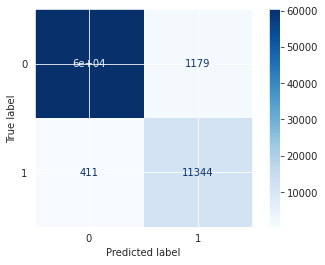

In [8]:
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, 
                            y_pred, 
                            target_names = ['Non-subscriber', 'subscriber']))                           
                             
plot_confusion_matrix(estimator=model, 
                      X=X_val, 
                      y_true=y_val, 
                      cmap='Blues'
                     )

In [9]:
joblib.dump(model, "chk_lgbm_model.joblib")

['chk_lgbm_model.joblib']

In [10]:
# calculate the f2-measure
from sklearn.metrics import fbeta_score

p = precision_score(y_val, 
                    y_pred)

r = recall_score(y_val, 
                 y_pred)

f = fbeta_score(y_val, 
                y_pred, 
                beta=2.0)

print('Result: precision=%.3f, recall=%.3f, f2-beta=%.3f' % (p, r, f))

Result: precision=0.906, recall=0.965, f2-beta=0.953


In [12]:
# beta_values=np.arange(0.5, 2.1, 0.1000)

# for beta in beta_values:
#     value=fbeta_score(y_val, y_pred, beta=beta,pos_label=1)
#     print("F-beta of lgbm on val set:","beta: ",round(beta,1)," F-beta Score: ",value)

In [13]:
# predicted subscriber rate = 17%

round((11344+1179)/(73253), 3)*100

17.1

* Feature importance using Shap

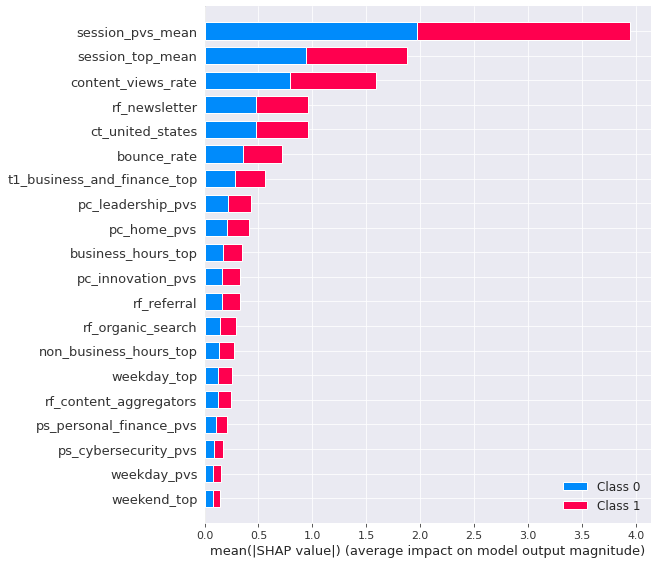

In [15]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(model)

shap_vals = explainer.shap_values(X_val) 

# SHAP values feat imp
shap.summary_plot(shap_vals, X_val)

<AxesSubplot:ylabel='feature'>

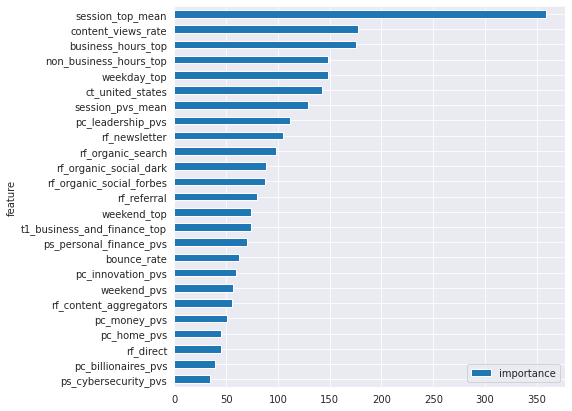

In [16]:
feature_importance = (
    pd.DataFrame({
        'feature': X_train.columns.tolist(),
        'importance': model.feature_importances_, #.steps[0][1]
    })
    .sort_values('importance', ascending=False)
)

feature_importance[:25].sort_values('importance') .plot(kind='barh', x='feature', y='importance', figsize=(7,7))

In [ ]:
# exlcude non-active subscribers -- DONE
# try without desktop/mobile features -- DONE
# shuffle train, val = true -- DONE
# predict on test set -- DONE
# shap feature importance on whole train and val sets --DONE

# when predicting on new people - see if all deskptop by any chance?